In [1]:
!kaggle datasets download -d nayansubedi1/airplane-crashes-and-fatalities-upto-2023

Dataset URL: https://www.kaggle.com/datasets/nayansubedi1/airplane-crashes-and-fatalities-upto-2023
License(s): DbCL-1.0
  0% 0.00/624k [00:00<?, ?B/s]
100% 624k/624k [00:00<00:00, 48.0MB/s]


In [2]:
!unzip airplane-crashes-and-fatalities-upto-2023.zip

Archive:  airplane-crashes-and-fatalities-upto-2023.zip
  inflating: Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv  


#Data Import
Importing the data from kaggle as well as the libraries for analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv',encoding='latin-1')

In [4]:
df.head()

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


#Data exploration
Exploring the data for data types, null values and duplicates.

In [6]:
df.isna().sum()

Date                        0
Time                     1512
Location                    4
Operator                   10
Flight #                 3669
Route                     777
AC Type                    15
Registration              274
cn/ln                     668
Aboard                     18
Aboard Passangers         229
Aboard Crew               226
Fatalities                  8
Fatalities Passangers     242
Fatalities Crew           241
Ground                     42
Summary                    64
dtype: int64

I'll drop the following:
- flight # because there are too many null values
- time because of relevance
- cn/ln because of relevance
- registration because of relevance

I could drop more columns but I'm not sure what I will want later on in the analysis.


In [7]:
df.drop(['Flight #','Time','cn/ln','Registration'],axis=1,inplace=True)

In [8]:
df.head()

,Date,Location,Operator,Route,AC Type,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,9/17/1908,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,"Juvisy-sur-Orge, France",NaN,Air show,Wright Byplane,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


In [10]:
df.duplicated().sum()

0

Populate the null values with the Mean as it is the simplest method.

In [11]:
df['Aboard'].fillna(df['Aboard'].mean(),inplace=True)
df['Fatalities'].fillna(df['Fatalities'].mean(),inplace=True)
df['Aboard Passangers'].fillna(df['Aboard Passangers'].mean(),inplace=True)
df['Aboard Crew'].fillna(df['Aboard Crew'].mean(),inplace=True)
df['Ground'].fillna(df['Ground'].mean(),inplace=True)
df['Ground'].dropna()
df['Operator'].dropna()
df['AC Type'].dropna()

0                       Wright Flyer III
1                         Wright Byplane
2                              Dirigible
3                       Curtiss seaplane
4                 Zeppelin L-1 (airship)
                      ...               
4993    Piper PA-31-350 Navajo Chieftain
4994                 ATR 72-500-72-212-A
4995       Embraer EMB-110P1 Bandeirante
4996           Cessna 208B Grand Caravan
4997                       \tLearjet 35A
Name: AC Type, Length: 4983, dtype: object

I noticed some Aboard values were null but there were crew or passengers listed as being aboard so I fixed that error here. Also added a Survival rate column for the survival rate per crash. I ran into a problem where there were listed fatalities but no-one was aboard so I got rows with -inf. I fixed it by replacing it with nan and then filling nan values as 0.

In [12]:
for index, row in df.iterrows():
  if row['Aboard']==0 and (row['Aboard Crew']!=0 or row['Aboard Passangers']!=0):
    df['Aboard']=df['Aboard Crew']+df['Aboard Passangers']

In [13]:
df['Survival rate']=100*((df['Aboard']-df['Fatalities'])/df['Aboard'])
df['Survival rate'].fillna(0,inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['Survival rate'].fillna(0, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   4998 non-null   object 
 1   Time                   3486 non-null   object 
 2   Location               4994 non-null   object 
 3   Operator               4988 non-null   object 
 4   Flight #               1329 non-null   object 
 5   Route                  4221 non-null   object 
 6   AC Type                4983 non-null   object 
 7   Registration           4724 non-null   object 
 8   cn/ln                  4330 non-null   object 
 9   Aboard                 4980 non-null   float64
 10  Aboard Passangers      4769 non-null   float64
 11  Aboard Crew            4772 non-null   float64
 12  Fatalities             4990 non-null   float64
 13  Fatalities Passangers  4756 non-null   float64
 14  Fatalities Crew        4757 non-null   float64
 15  Grou

The only coliumn which needed reclassification was the date column.

In [14]:
df['Date']=pd.to_datetime(df['Date'],format='%m/%d/%Y')


In [15]:
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year

In [16]:
df.head()

,Date,Location,Operator,Route,AC Type,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary,Survival rate,Month,Year
0,1908-09-17,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",50.000,9,1908
1,1909-09-07,"Juvisy-sur-Orge, France",NaN,Air show,Wright Byplane,1.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,0.000,9,1909
2,1912-07-12,"Atlantic City, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.000000,0.000000,5.000000,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,0.000,7,1912
3,1913-08-06,"Victoria, British Columbia, Canada",Private,NaN,Curtiss seaplane,1.000000,0.000000,1.000000,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,0.000,8,1913
4,1913-09-09,Over the North Sea,Military - German Navy,NaN,Zeppelin L-1 (airship),31.488271,27.009017,4.479254,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,55.539,9,1913


#EDA

Exploring the data using statistical values to understand the distribution of fatalities.

In [81]:
df.describe()

,Date,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Survival rate,Month,Year
count,4998,4998.000000,4998.000000,4998.000000,4998.000000,4756.000000,4757.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,1971-07-04 09:31:37.238895528,31.488271,27.009017,4.479254,22.373547,19.053827,3.578516,1.719128,19.513694,6.700880,1970.990796
min,1908-09-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-309.676358,1.000000,1908.000000
25%,1951-06-15 06:00:00,7.000000,3.000000,2.000000,4.000000,1.000000,2.000000,0.000000,0.000000,4.000000,1951.000000
50%,1970-11-27 00:00:00,17.000000,13.000000,4.000000,11.000000,8.000000,3.000000,0.000000,0.000000,7.000000,1970.000000
75%,1992-06-06 18:00:00,34.000000,29.000000,5.000000,25.000000,21.000000,5.000000,0.000000,33.308500,10.000000,1992.000000
max,2023-11-01 00:00:00,644.000000,614.000000,61.000000,583.000000,560.000000,46.000000,2750.000000,100.000000,12.000000,2023.000000
std,NaN,45.082771,43.088993,3.404165,35.033663,34.146127,3.167922,55.306371,32.698202,3.531153,24.796492


In [18]:
num_crashes = len(df)
num_fatalities = df['Fatalities'].sum()
survival_rate = (df['Aboard'].sum()-df['Fatalities'].sum())/df['Aboard'].sum()

print(f"Number of Crashes: {num_crashes}")
print(f"Number of Fatalities: {num_fatalities.round(0)}")
print(f"Survival Rate: {survival_rate:.2%}")

Number of Crashes: 4998
Number of Fatalities: 111823.0
Survival Rate: 28.95%


In [19]:
grouped = df.groupby('Year')['Year'].count()
print(grouped)

Year
1908     1
1909     1
1912     1
1913     3
1915     2
        ..
2019    13
2020     8
2021     9
2022     6
2023     4
Name: Year, Length: 113, dtype: int64


Text(0.5, 1.0, 'Distribution of Crashes by Year vs the rolling 5 year average')

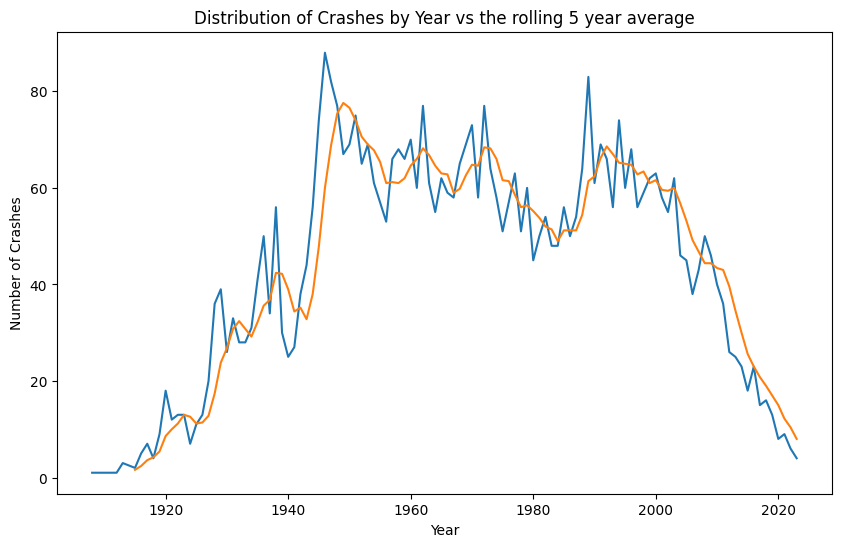

In [88]:
plt.figure(figsize=(10,6))
plt.plot(grouped)
plt.plot(grouped.rolling(window=5).mean())
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.title('Distribution of Crashes by Year vs the rolling 5 year average')

On initial inspection it is evident that there was a large spike in fatalities from the 1940s and only really started to taper around 2000. This is most likely due to the rise in popularity of airfare around the 40s.

In [21]:
mean_fatalities = df['Fatalities'].mean()
median_fatalities = np.median(df['Fatalities'])
std_fatalities = stats.tstd(df['Fatalities'])

mean_survival_rate = np.mean(df['Survival rate'])
median_survival_rate = np.nanmedian(df['Survival rate'])
std_survival_rate = np.std(df['Survival rate'])

print(f"Mean Number of Fatalities: {mean_fatalities}")
print(f"Mean Survival Rate: {mean_survival_rate.round(2)}")
print(f"Median Number of Fatalities: {median_fatalities}")
print(f"Median Survival Rate: {median_survival_rate.round(2)}")
print(f"Standard Deviation of Number of Fatalities: {std_fatalities.round(2)}")
print(f"Standard Deviation of Survival Rate: {std_survival_rate.round(2)}")

Mean Number of Fatalities: 22.37354709418838
Mean Survival Rate: 19.51
Median Number of Fatalities: 11.0
Median Survival Rate: 0.0
Standard Deviation of Number of Fatalities: 35.03
Standard Deviation of Survival Rate: 32.69


Hypothesis testing:

Null: There is no significant difference in fatalities over the decades

In [22]:
decade_1 = df[(df['Year'] >= 1920) & (df['Year'] < 1930)]['Fatalities']
decade_2 = df[(df['Year'] >= 1930) & (df['Year'] < 1940)]['Fatalities']
decade_3 = df[(df['Year'] >= 1940) & (df['Year'] < 1950)]['Fatalities']
decade_4 = df[(df['Year'] >= 1950) & (df['Year'] < 1960)]['Fatalities']
decade_5 = df[(df['Year'] >= 1960) & (df['Year'] < 1970)]['Fatalities']
decade_6 = df[(df['Year'] >= 1970) & (df['Year'] < 1980)]['Fatalities']
decade_7 = df[(df['Year'] >= 1980) & (df['Year'] < 1990)]['Fatalities']
decade_8 = df[(df['Year'] >= 1990) & (df['Year'] < 2000)]['Fatalities']
decade_9 = df[(df['Year'] >= 2000) & (df['Year'] < 2010)]['Fatalities']
decade_10 = df[(df['Year'] >= 2010) & (df['Year'] < 2020)]['Fatalities']

decades1 = pd.concat([decade_1,decade_2,decade_3,decade_4,decade_5])
decades2 =  pd.concat([decade_6,decade_7,decade_8,decade_9,decade_10] )

tstat, pvalue = stats.ttest_ind(decades1, decades2)
print(f"t-statistic: {tstat}")
print(f"p-value: {pvalue}")

alpha =0.05
if pvalue < alpha:
    print("Reject the null hypothesis. There is a significant difference in fatalities over the decades.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in fatalities over the decades.")

t-statistic: -10.9886268926226
p-value: 9.073361492123518e-28
Reject the null hypothesis. There is a significant difference in fatalities over the decades.


Null: There is no significant difference in number of passengers aboard over time

In [23]:
decade_1 = df[(df['Year'] >= 1920) & (df['Year'] < 1930)]['Aboard']
decade_2 = df[(df['Year'] >= 1930) & (df['Year'] < 1940)]['Aboard']
decade_3 = df[(df['Year'] >= 1940) & (df['Year'] < 1950)]['Aboard']
decade_4 = df[(df['Year'] >= 1950) & (df['Year'] < 1960)]['Aboard']
decade_5 = df[(df['Year'] >= 1960) & (df['Year'] < 1970)]['Aboard']
decade_6 = df[(df['Year'] >= 1970) & (df['Year'] < 1980)]['Aboard']
decade_7 = df[(df['Year'] >= 1980) & (df['Year'] < 1990)]['Aboard']
decade_8 = df[(df['Year'] >= 1990) & (df['Year'] < 2000)]['Aboard']
decade_9 = df[(df['Year'] >= 2000) & (df['Year'] < 2010)]['Aboard']
decade_10 = df[(df['Year'] >= 2010) & (df['Year'] < 2020)]['Aboard']

decades1 = pd.concat([decade_1,decade_2,decade_3,decade_4,decade_5])
decades2 =  pd.concat([decade_6,decade_7,decade_8,decade_9,decade_10] )

tstat, pvalue = stats.ttest_ind(decades1, decades2)
print(f"t-statistic: {tstat}")
print(f"p-value: {pvalue}")

alpha =0.05
if pvalue < alpha:
    print("Reject the null hypothesis. There is a significant difference in passengers over the decades.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in passengers over the decades.")

t-statistic: -14.639183164389257
p-value: 1.5475359610910013e-47
Reject the null hypothesis. There is a significant difference in passengers over the decades.


#Visualisations
Visualising the data using matplotlib and seaborn to see the distribution of the data.

Using a pairplot to visualise all the interactions between the variables

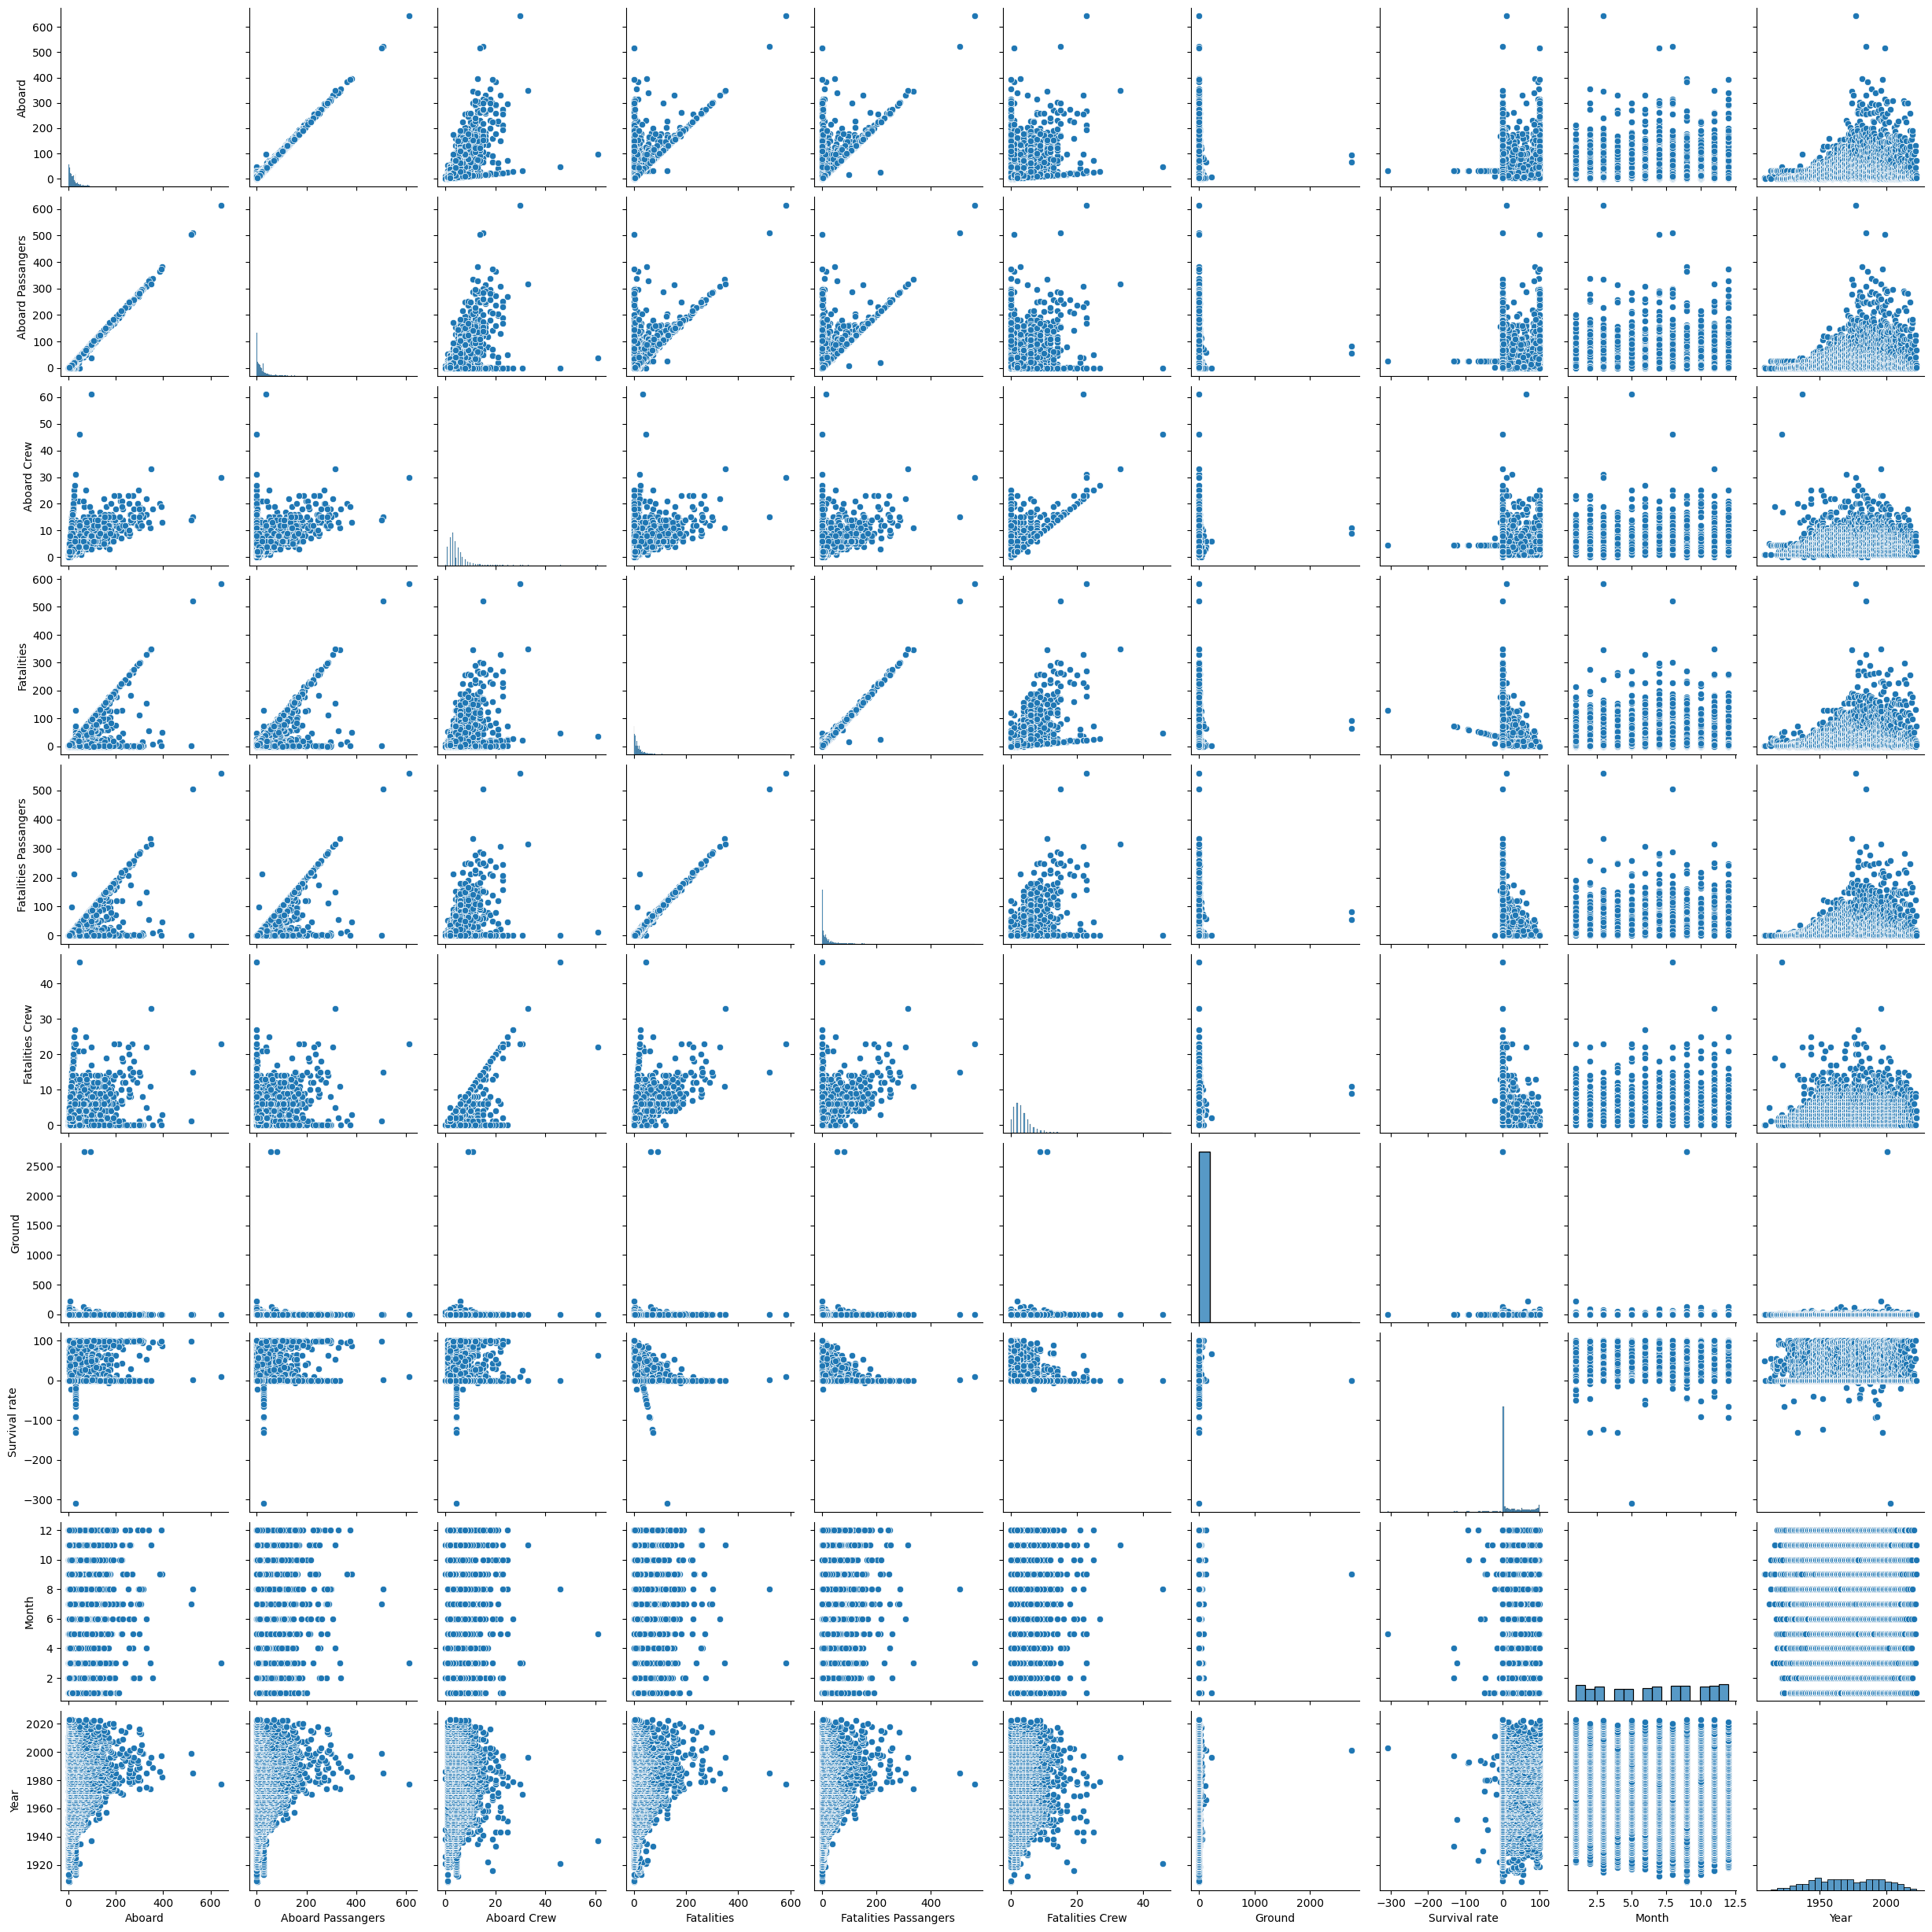

In [24]:
sns.pairplot(df)


<Axes: >

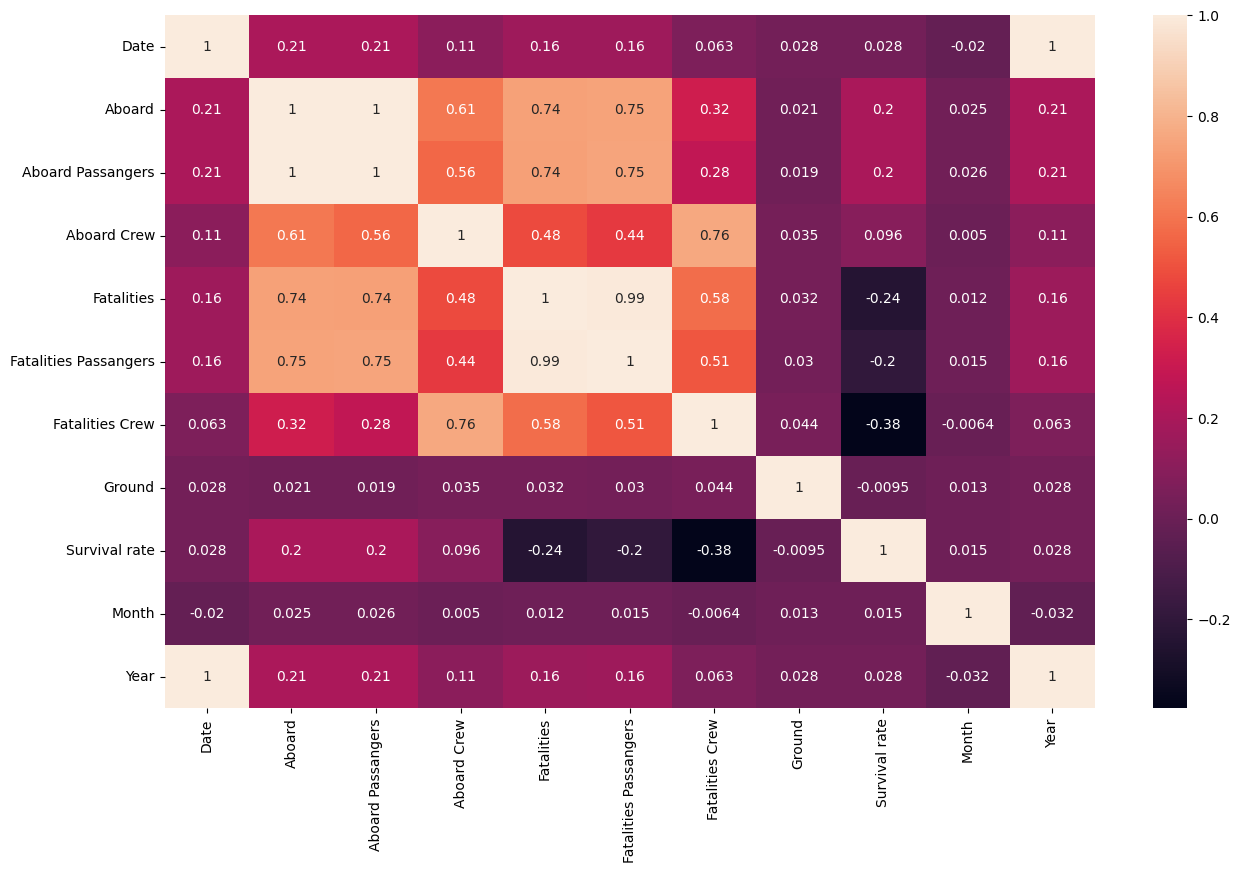

In [25]:
df_heatmap  = df.drop(['Location','Operator','Route','AC Type','Summary'],axis=1)
df_heatmap.head()
plt.figure(figsize=(15,9))
sns.heatmap(df_heatmap.corr(),annot=True)

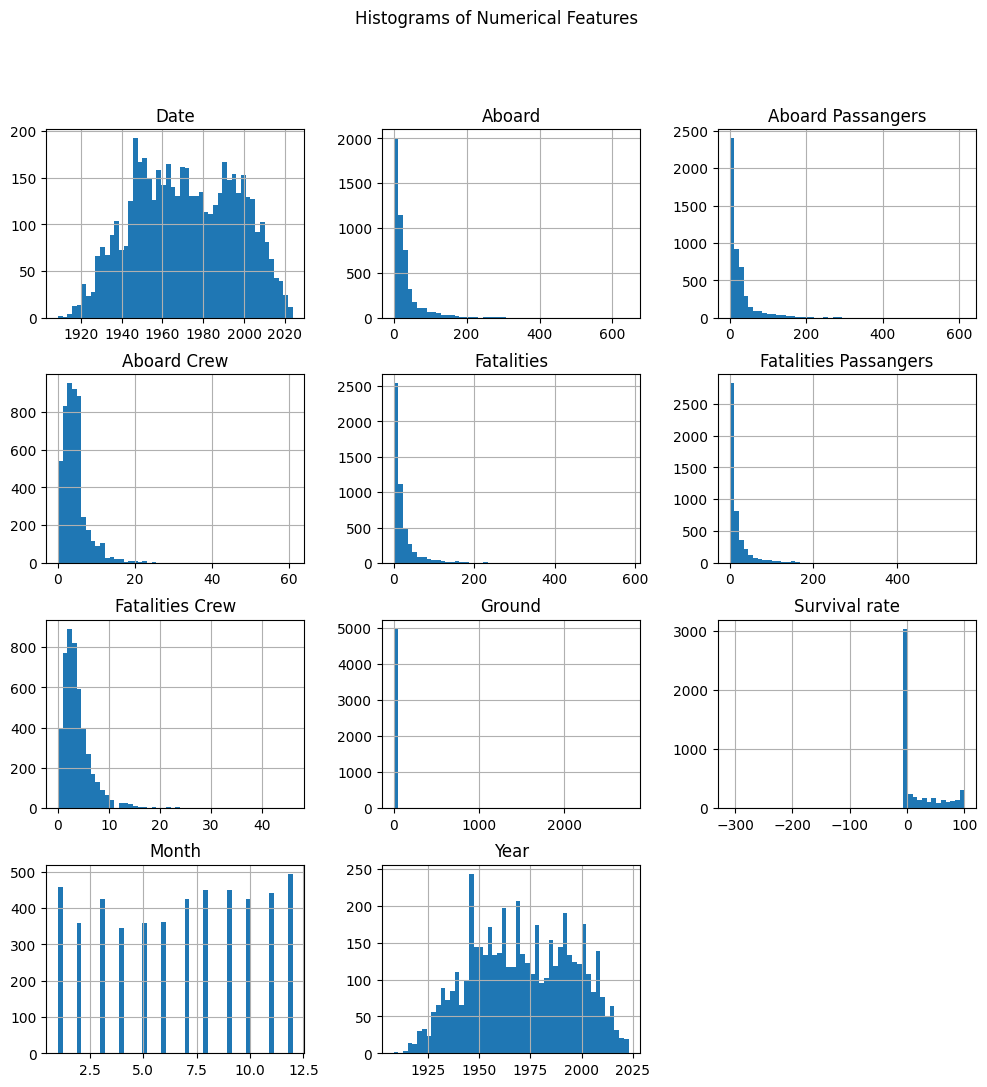

In [26]:
df.hist(figsize=(12, 12), bins=50)
plt.suptitle('Histograms of Numerical Features')
plt.show()

Summary:

From these general data graphs, there does not appear to be any surprising trends/correlations that weren't already known/identified. For example, there is a positive correlation between passengers onboard and total onboard - this is obvious.

In terms of the histograms, most of the data is positively skewed with the data falling below the mean. This makes sense as most of the data has lower number of recorded people onboard with a few number of outliers.


In [27]:
df_passengers = df.groupby('Year')['Aboard'].sum().reset_index()
df_passengers.head()

,Year,Aboard
0,1908,2.000000
1,1909,1.000000
2,1912,5.000000
3,1913,63.976541
4,1915,62.976541


Text(0.5, 1.0, 'Distribution of passengers onboard crashes')

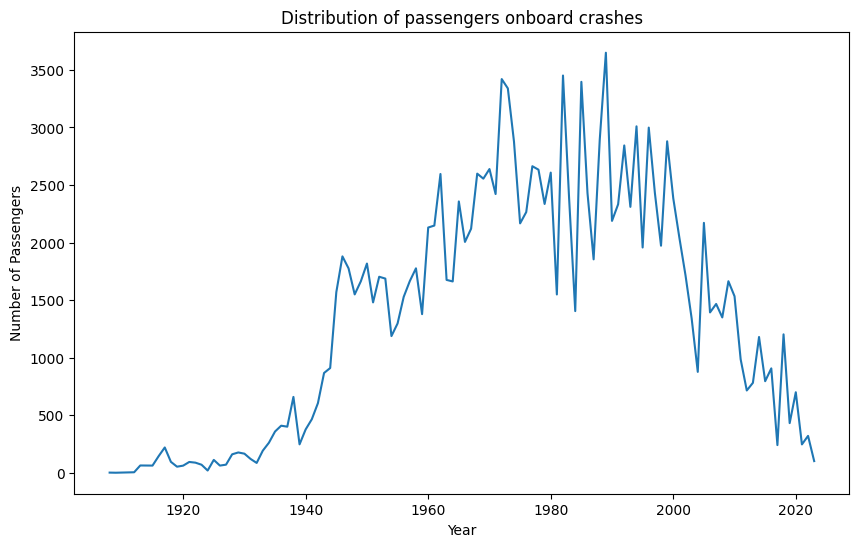

In [28]:
plt.figure(figsize=(10,6))
plt.plot(df_passengers['Year'],df_passengers['Aboard'])

plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.title('Distribution of passengers onboard crashes')

The spiike in passengers from 1940 to 1950 is attributed to commercial aviation overtaking rail as the more popular form of travel.

In [30]:
df_survival = df.groupby('Year')['Survival rate'].mean().reset_index()
df_survival.head()

,Year,Survival rate
0,1908,50.000000
1,1909,0.000000
2,1912,0.000000
3,1913,20.088476
4,1915,36.484286


Text(0.5, 1.0, 'Distribution of survival rates')

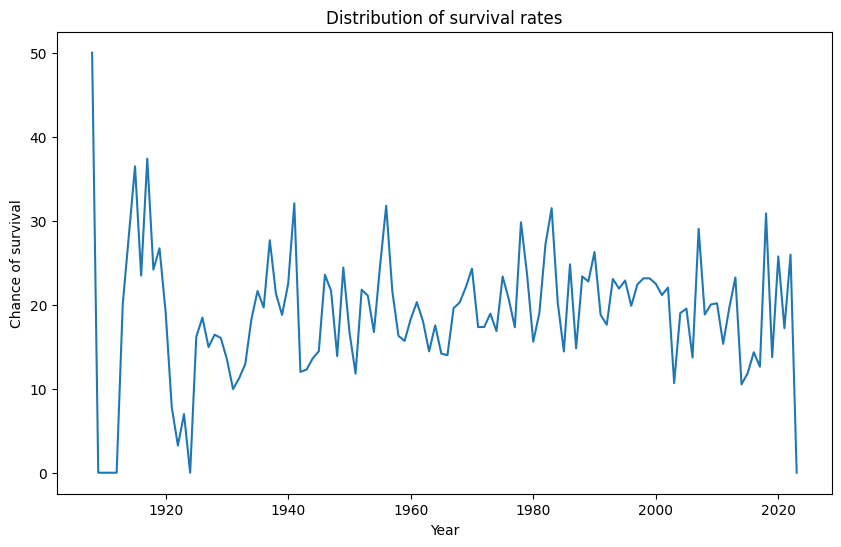

In [31]:
plt.figure(figsize=(10,6))
plt.plot(df_survival['Year'],df_survival['Survival rate'])
plt.xlabel('Year')
plt.ylabel('Chance of survival')
plt.title('Distribution of survival rates')

I would have thought that survival rates would have increased in a more positively linear fashion.

In [32]:
df_by_year = df.groupby('Year')['Fatalities'].sum().reset_index()
df_by_year.head()

,Year,Fatalities
0,1908,1.0
1,1909,1.0
2,1912,5.0
3,1913,45.0
4,1915,40.0


Text(0.5, 1.0, 'Distribution of fatalities')

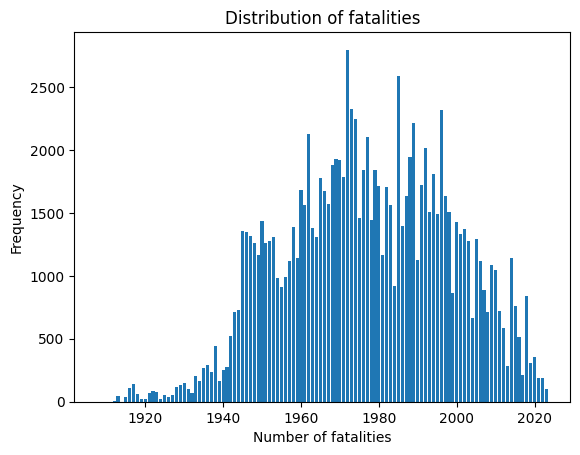

In [37]:
plt.bar(df_by_year['Year'],df_by_year['Fatalities'])
plt.xlabel('Number of fatalities')
plt.ylabel('Frequency')
plt.title('Distribution of fatalities')

Given this graph I suspect my maths is wrong on the survival rate graph above.

In [61]:
df_by_region = df.groupby('Location')['Fatalities'].sum().reset_index()
df_by_region['Country']=df_by_region['Location'].str.split(',').str[1]
df_by_region.drop('Location',axis=1,inplace=True)

df_region_grouped=df_by_region.groupby('Country')['Fatalities'].sum().reset_index()
df_region_grouped.sort_values('Fatalities',ascending=False,inplace=True)
df_region_grouped = df_region_grouped[df_region_grouped['Fatalities']>500]
df_region_grouped.head()

,Country,Fatalities
456,Russia,8169.0
104,Brazil,2934.0
144,Colombia,2688.0
253,India,2362.0
258,Indonesia,2305.0


Text(0.5, 1.0, 'Distribution of fatalities by region')

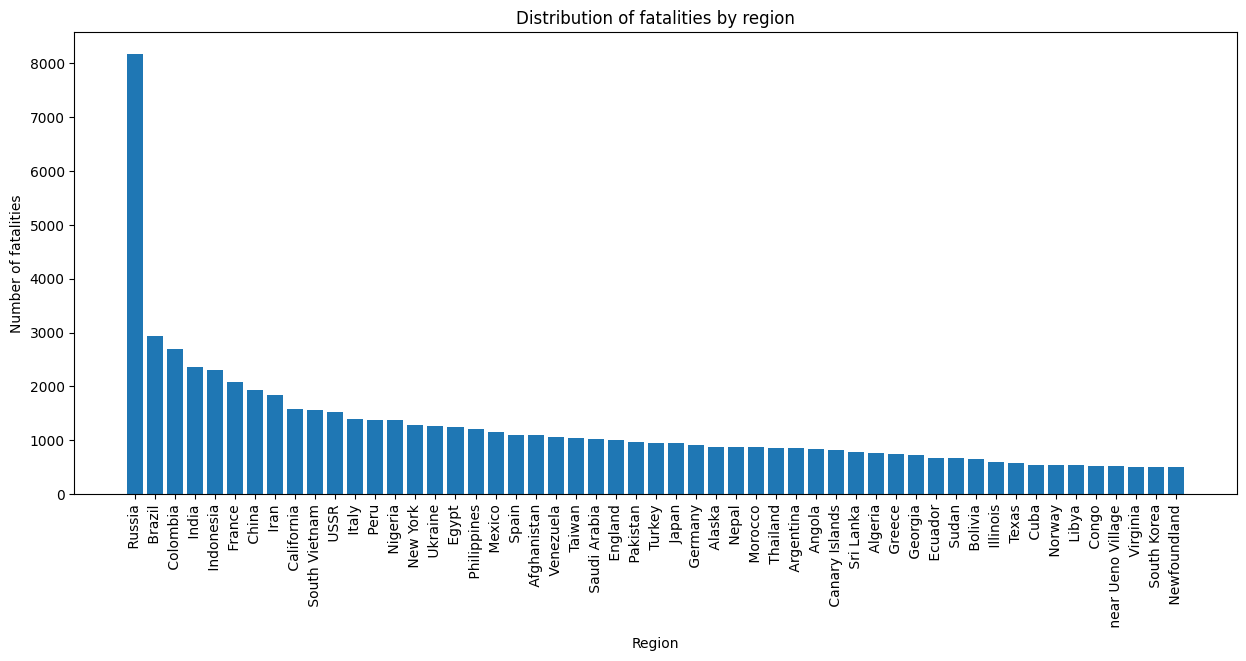

In [53]:
plt.figure(figsize=(15,6))
plt.bar(df_region_grouped['Country'],df_region_grouped['Fatalities'])
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Number of fatalities')
plt.title('Distribution of fatalities by region')


In [60]:
plt.figure(figsize=(15,6))

fig = px.scatter(df_region_grouped, x='Country', y='Fatalities', size='Fatalities', color='Country',
                 title='Bubble Chart Example', labels={'Variable1': 'X-axis', 'Variable2': 'Y-axis'})

fig.show()

<Figure size 1500x600 with 0 Axes>

I filtered the data for crashes with over 500 Fatalities. It's interesting how Russia is such an outlier amongst the nations with nearly 3x more then the next country.

In [79]:
df_Russia = df.groupby(['Location','Year'])['Fatalities'].sum().reset_index()
df_Russia['Country']=df_Russia['Location'].str.split(',').str[1]
df_Russia.drop('Location',axis=1,inplace=True)

df_Russia = df_Russia[df_Russia['Country']==' Russia']
df_Russia.sort_values('Year',ascending=True,inplace=True)
df_Russia.head()

<ipython-input-79-7fb313aa6891>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Fatalities,Country
4484,1929,1.0,Russia
2912,1935,50.0,Russia
2913,1936,9.0,Russia
1413,1938,13.0,Russia
2703,1942,20.0,Russia


Text(0.5, 1.0, 'Distribution of fatalities in Russia')

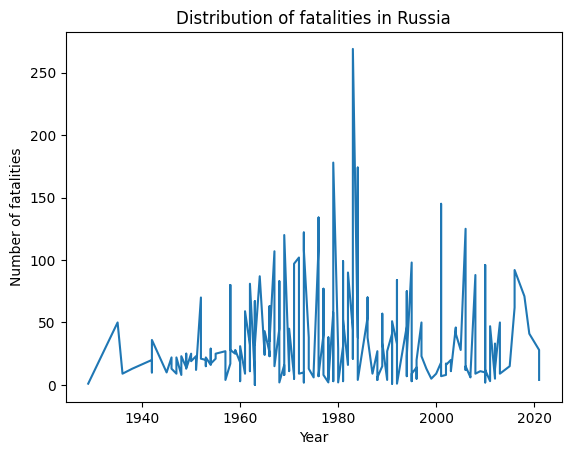

In [80]:
plt.plot(df_Russia['Year'],df_Russia['Fatalities'])
plt.xlabel('Year')
plt.ylabel('Number of fatalities')
plt.title('Distribution of fatalities in Russia')

Russia had a really bad few years around the 1980s

#Conclusion

From the data it is clear to see there was a high fatality rate between the 60's and 2000s, especially around the 1980s. Some of the reasons include:

1. Rapid Expansion of Air Travel:

The 1960s through the 1980s were periods of significant growth in commercial aviation. More flights and new airlines meant an increase in the number of flights while aircraft design and saftety protocols were still maturing. All of this combined lead to a higher probability of accidents.

2. Regulatory Standards:

Aviation regulations and standards were still being developed and refined. This period saw the implementation of many critical regulations that have since improved safety, but the learning curve involved some tragic accidents.

3. High-Profile Crashes:

Several high-profile crashes during the 1970s and 1980s, such as the Tenerife airport disaster in 1977 (the deadliest aviation accident in history), or the Aeroflot accidents in Russia in 1985, contributed significantly to the fatality statistics.